In [1]:
!pip install gdown
!gdown --id '1Mke0bIjd2Ui0NNsDOGwxelQukwE2daku' -O /kaggle/working/student_6_6_3072_model_final.pth


/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1Mke0bIjd2Ui0NNsDOGwxelQukwE2daku
From (redirected): https://drive.google.com/uc?id=1Mke0bIjd2Ui0NNsDOGwxelQukwE2daku&confirm=t&uuid=dc332fef-26a6-45b1-8167-8175755688e9
To: /kaggle/working/student_6_6_3072_model_final.pth
100%|████████████████████████████████████████| 119M/119M [00:01<00:00, 78.8MB/s]


In [5]:
import os
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from datasets import Dataset
from transformers import BertTokenizerFast, BertModel, BertConfig, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample

# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

# Load the data
train_data = pd.read_csv('/kaggle/input/medcon/medical_tc_train.csv')
test_data = pd.read_csv('/kaggle/input/medcon/medical_tc_test.csv')

# Define the condition labels and their names
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases",
    5: "general pathological conditions"
}

# Remove the "general pathological conditions" class (label 5)
train_data = train_data[train_data['condition_label'] != 5]
test_data = test_data[test_data['condition_label'] != 5]

# Update the label dictionary to exclude "general pathological conditions"
label_dict = {
    1: "neoplasms",
    2: "digestive system diseases",
    3: "nervous system diseases",
    4: "cardiovascular diseases"
}

# Encode the labels (subtract 1 to make them zero-indexed)
train_data['condition_label'] = train_data['condition_label'].astype(int) - 1
test_data['condition_label'] = test_data['condition_label'].astype(int) - 1

# Determine the target size for balancing
target_size = train_data['condition_label'].value_counts().max()

# Separate each class into a different dataframe
dfs = [train_data[train_data.condition_label == i] for i in range(len(label_dict))]

# Upsample minority classes to the target size
dfs_balanced = [resample(df, replace=True, n_samples=int(target_size), random_state=123) if len(df) < target_size else df for df in dfs]

# Combine all the balanced dataframes
train_data_balanced = pd.concat(dfs_balanced)

# Print the class distribution after balancing
print("Class distribution after balancing:")
print(train_data_balanced['condition_label'].value_counts())

# Rename 'condition_label' to 'labels' for consistency with Hugging Face datasets
train_data_balanced.rename(columns={'condition_label': 'labels'}, inplace=True)
test_data.rename(columns={'condition_label': 'labels'}, inplace=True)

# Split the training data into training and validation sets
train_data, val_data = train_test_split(train_data_balanced, test_size=0.2, stratify=train_data_balanced['labels'], random_state=42)

# Convert the data to Hugging Face datasets
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

# Tokenize the data
def tokenize_function(examples):
    return tokenizer(examples['medical_abstract'], padding="max_length", truncation=True, max_length=512)

train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set the format for PyTorch
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
val_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

# Create Custom Student Model with Dropout
class CustomBERTModel(BertForSequenceClassification):
    def __init__(self, config):
        super(CustomBERTModel, self).__init__(config)
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(p=0.3)
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.config.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else (logits,)

# Initialize custom student model
def create_custom_student_model():
    student_config = BertConfig.from_pretrained("bert-base-uncased")
    student_config.hidden_size = 384
    student_config.num_attention_heads = 6
    student_config.num_hidden_layers = 6
    student_config.intermediate_size = 3072
    student_config.num_labels = len(label_dict)  # Number of labels in the classification task
    return CustomBERTModel(student_config)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
student_model = create_custom_student_model().to(device)

# Load the state dictionary into the custom student model
model_path = '/kaggle/working/student_6_6_3072_model_final.pth'
state_dict = torch.load(model_path, map_location=device)

# Filter out keys that are not present in the classification model
filtered_state_dict = {k: v for k, v in state_dict.items() if k in student_model.state_dict()}

# Load the filtered state dictionary
student_model.load_state_dict(filtered_state_dict, strict=False)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=10,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=100,
    weight_decay=0.1,
    logging_dir='./logs',
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    greater_is_better=False
)

# Define compute metrics function
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(p.label_ids, preds, average='weighted')
    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': (preds == p.label_ids).mean()
    }

# Initialize the Trainer
trainer = Trainer(
    model=student_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
train_result = trainer.train()
metrics = train_result.metrics
trainer.save_model()

# Evaluate the model on the validation set
eval_results = trainer.evaluate()
print(f"Evaluation results on validation set: {eval_results}")

Class distribution after balancing:
condition_label
0    2530
1    2530
2    2530
3    2530
Name: count, dtype: int64


Map:   0%|          | 0/8096 [00:00<?, ? examples/s]

Map:   0%|          | 0/2024 [00:00<?, ? examples/s]

Map:   0%|          | 0/1927 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.823400,0.496631,0.832796,0.827569,0.826299,0.827569
2,0.414400,0.408817,0.864038,0.863636,0.863351,0.863636
3,0.307300,0.381558,0.874255,0.872530,0.872538,0.872530
4,0.246000,0.397666,0.875778,0.873024,0.873667,0.873024
5,0.203800,0.462598,0.872227,0.871047,0.870609,0.871047


Evaluation results on validation set: {'eval_loss': 0.3815584182739258, 'eval_precision': 0.8742549420019856, 'eval_recall': 0.8725296442687747, 'eval_f1': 0.8725382299480825, 'eval_accuracy': 0.8725296442687747, 'eval_runtime': 7.7149, 'eval_samples_per_second': 262.349, 'eval_steps_per_second': 16.462, 'epoch': 5.0}


Test Precision: 0.8051
Test Recall: 0.7976
Test F1 Score: 0.8000


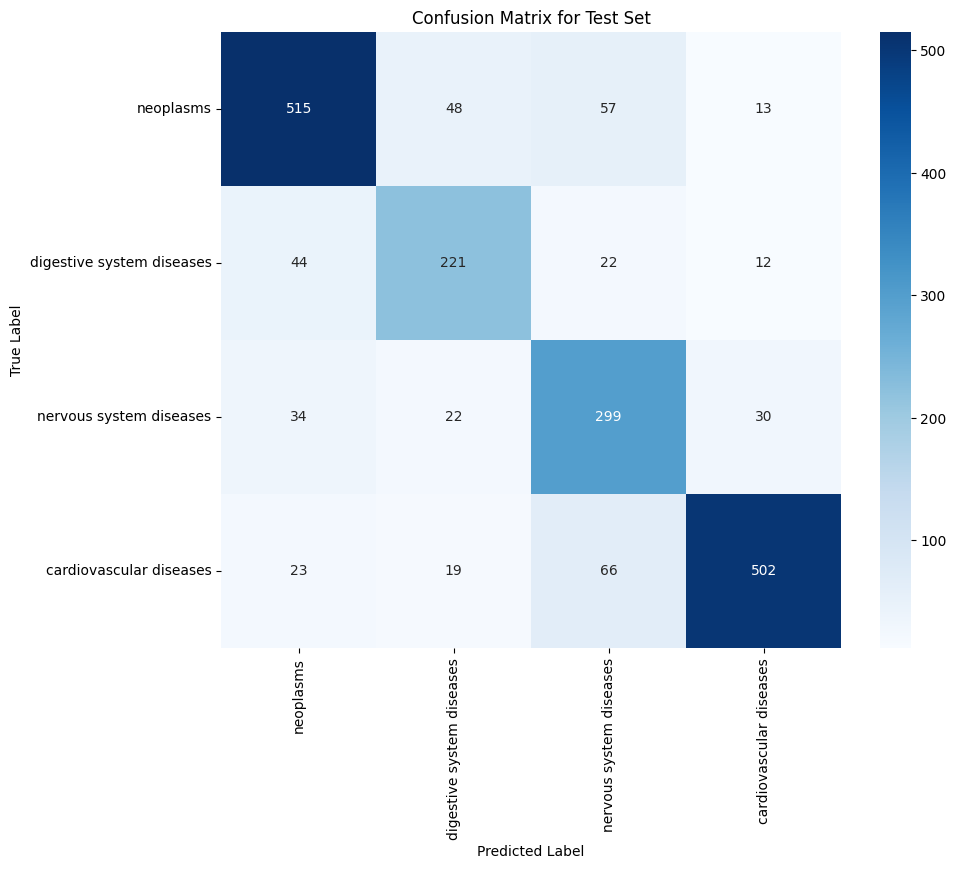

                           precision    recall  f1-score   support

                neoplasms       0.84      0.81      0.82       633
digestive system diseases       0.71      0.74      0.73       299
  nervous system diseases       0.67      0.78      0.72       385
  cardiovascular diseases       0.90      0.82      0.86       610

                 accuracy                           0.80      1927
                macro avg       0.78      0.79      0.78      1927
             weighted avg       0.81      0.80      0.80      1927



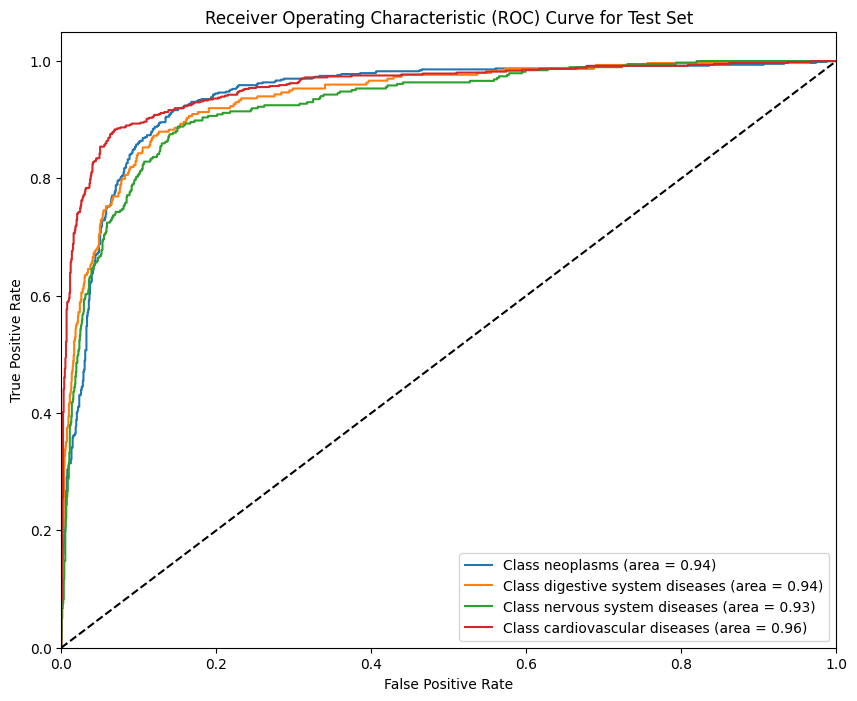

ValueError: x and y must have same first dimension, but have shapes (5,) and (0,)

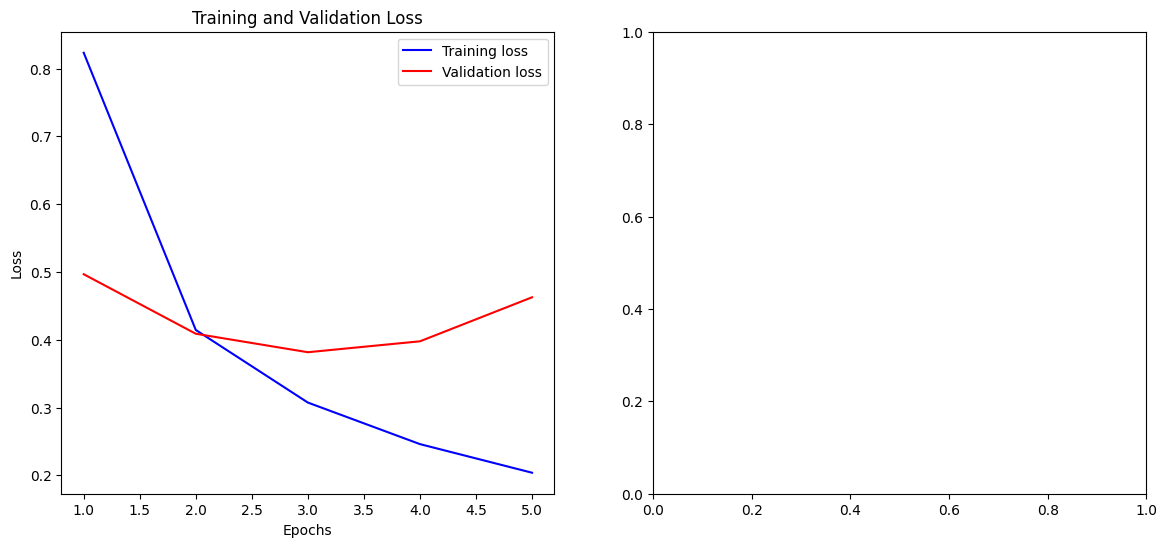

In [6]:
# Evaluate the model on the test set
test_results = trainer.predict(test_dataset)
test_preds = np.argmax(test_results.predictions, axis=1)
test_labels = test_results.label_ids

# Calculate precision, recall, f1-score for test set
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_labels, test_preds, average='weighted')
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Confusion matrix for test set
conf_matrix = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_dict.values(), yticklabels=label_dict.values())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Test Set')
plt.show()

# Classification report for test set
test_report = classification_report(test_labels, test_preds, target_names=label_dict.values())
print(test_report)

# ROC Curve and AUROC for test set
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(label_dict)):
    fpr[i], tpr[i], _ = roc_curve(test_labels, test_results.predictions[:, i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(label_dict)):
    plt.plot(fpr[i], tpr[i], label=f'Class {label_dict[i+1]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Test Set')
plt.legend(loc='lower right')
plt.show()

# Extract losses and accuracy values
training_logs = trainer.state.log_history

train_loss_values = [log['loss'] for log in training_logs if 'loss' in log]
val_loss_values = [log['eval_loss'] for log in training_logs if 'eval_loss' in log]
train_acc_values = [log['accuracy'] for log in training_logs if 'accuracy' in log]
val_acc_values = [log['eval_accuracy'] for log in training_logs if 'eval_accuracy' in log]

# Ensure equal length for plotting
min_len = min(len(train_loss_values), len(val_loss_values))
train_loss_values = train_loss_values[:min_len]
val_loss_values = val_loss_values[:min_len]
train_acc_values = train_acc_values[:min_len]
val_acc_values = val_acc_values[:min_len]
epochs = range(1, min_len + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_values, 'b', label='Training loss')
plt.plot(epochs, val_loss_values, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_values, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc_values, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

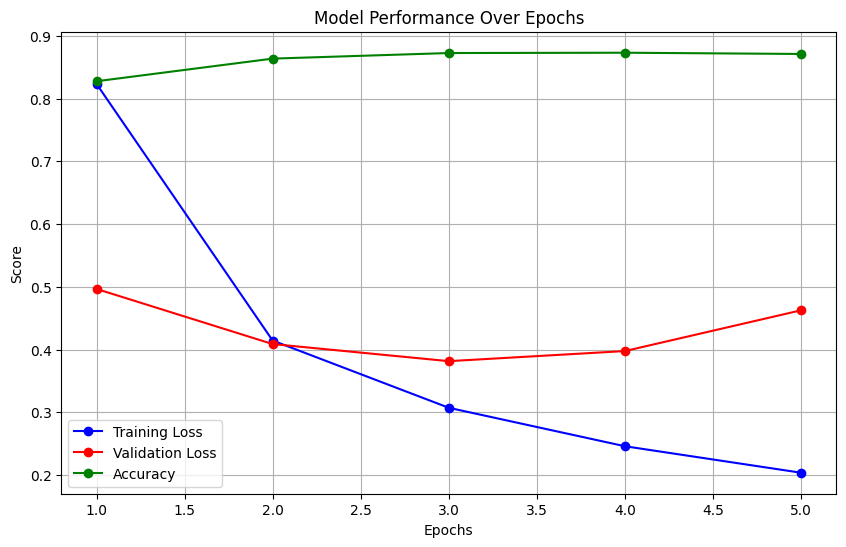

In [7]:
import matplotlib.pyplot as plt

# Data from training logs
epochs = [1, 2, 3, 4, 5]
training_loss = [0.823400, 0.414400, 0.307300, 0.246000, 0.203800]
validation_loss = [0.496631, 0.408817, 0.381558, 0.397666, 0.462598]
precision = [0.832796, 0.864038, 0.874255, 0.875778, 0.872227]
recall = [0.827569, 0.863636, 0.872530, 0.873024, 0.871047]
f1_score = [0.826299, 0.863351, 0.872538, 0.873667, 0.870609]
accuracy = [0.827569, 0.863636, 0.872530, 0.873024, 0.871047]


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, training_loss, 'b-o', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-o', label='Validation Loss')
plt.plot(epochs, accuracy, 'g-o', label='Accuracy')

# Titles and labels
plt.title('Model Performance Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show plot
plt.show()


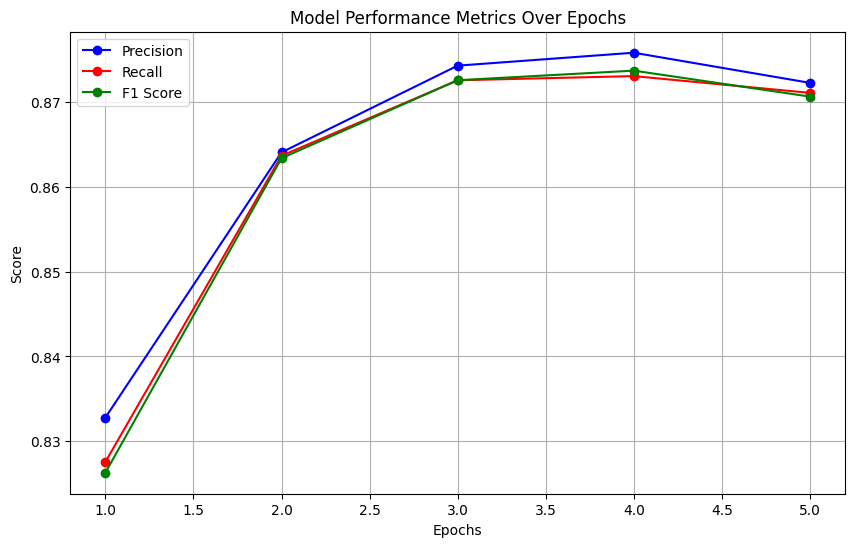

In [8]:
# Data from training logs
epochs = [1, 2, 3, 4, 5]
training_loss = [0.823400, 0.414400, 0.307300, 0.246000, 0.203800]
validation_loss = [0.496631, 0.408817, 0.381558, 0.397666, 0.462598]
precision = [0.832796, 0.864038, 0.874255, 0.875778, 0.872227]
recall = [0.827569, 0.863636, 0.872530, 0.873024, 0.871047]
f1 = [0.826299, 0.863351, 0.872538, 0.873667, 0.870609]
accuracy = [0.827569, 0.863636, 0.872530, 0.873024, 0.871047]


# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, precision, 'b-o', label='Precision')
plt.plot(epochs, recall, 'r-o', label='Recall')
plt.plot(epochs, f1, 'g-o', label='F1 Score')

# Titles and labels
plt.title('Model Performance Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)

# Show plot
plt.show()